In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shan2307/goldrate-chennai-2012-2025")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/goldrate-chennai-2012-2025


In [2]:
!git clone https://github.com/kwuking/TimeMixer.git
%cd TimeMixer

Cloning into 'TimeMixer'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 381 (delta 126), reused 94 (delta 91), pack-reused 197 (from 1)
Receiving objects: 100% (381/381), 5.38 MiB | 23.94 MiB/s, done.
Resolving deltas: 100% (209/209), done.
/content/TimeMixer


In [3]:
!pip install yfinance

In [4]:
!pip install datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00


In [5]:
!pip install git+https://github.com/Nixtla/neuralforecast.git

  Cloning https://github.com/Nixtla/neuralforecast.git to /tmp/pip-req-build-dge1pm0h
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-dge1pm0h
  Resolved https://github.com/Nixtla/neuralforecast.git to commit ad31fd18f503742f46c2147f9ed8664c1e3cc13d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━

In [46]:
# import necessary datasets
import warnings
warnings.filterwarnings('ignore')

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import yfinance as yf
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
import polars as pl

import torch
from datasetsforecast.m3 import M3
from datasetsforecast.long_horizon import LongHorizon

from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.models import TimeMixer, PatchTST, iTransformer, NHITS, NBEATS

from utilsforecast.losses import mae, mse, smape
from utilsforecast.evaluation import evaluate

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# data extraction
def list_and_load_csvs(directory, n_rows=5):
    """
    Lists CSV files in a directory and loads+previews each one.

    Args:
        directory (str): Path to the directory.
        n_rows (int): Number of rows to show from each CSV.
    """
    try:
        files = os.listdir(directory)
        csv_files = [f for f in files if f.lower().endswith('.csv')]

        if not csv_files:
            print("[Info] No CSV files found in the directory.")
            return

        print(f"[Info] Found {len(csv_files)} CSV file(s): {csv_files}\n")

        for csv_file in csv_files:
            file_path = os.path.join(directory, csv_file)
            print(f"\n[Loading] {csv_file} ...")
            df = pd.read_csv(file_path)
            print(df.head(n_rows))

        return df

    except Exception as e:
        print(f"[Exception] {e}")

directory_path = path
df = list_and_load_csvs(directory_path)

[Info] Found 1 CSV file(s): ['GoldRate - History_Data.csv']


[Loading] GoldRate - History_Data.csv ...
         Date  22K Rate  24K Rate  Month  Year
0  02/01/2012  2,560.00  2,738.00      1  2012
1  03/01/2012  2,582.00  2,762.00      1  2012
2  04/01/2012  2,598.00  2,778.50      1  2012
3  05/01/2012  2,607.00  2,788.00      1  2012
4  06/01/2012  2,623.00  2,805.00      1  2012


In [8]:
print(f'The Shape of the Gold Rate dataset: {df.shape}')
print(f'The rows of the Gold Rate dataset: {df.shape[0]}')
print(f'The columns of the Gold Rate dataset: {df.shape[1]}')
print(df.columns.to_list)

The Shape of the Gold Rate dataset: (4769, 5)
The rows of the Gold Rate dataset: 4769
The columns of the Gold Rate dataset: 5
<bound method IndexOpsMixin.tolist of Index(['Date', '22K Rate', '24K Rate', 'Month', 'Year'], dtype='object')>


In [9]:
# rename columns
df.rename(columns={'Date': 'date', '22K Rate': '22krate', '24K Rate': '24krate', 'Month': 'month', 'Year': 'year'}, inplace=True)
print(df.columns.to_list)

<bound method IndexOpsMixin.tolist of Index(['date', '22krate', '24krate', 'month', 'year'], dtype='object')>


In [10]:
# Convert Date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

In [11]:
import pandas as pd

def clean_dataframe(df, sort_by=None, drop_na="any"):
    """
    Cleans a pandas DataFrame by:
        - Dropping duplicates
        - Dropping NaN rows
        - Reseting index
        - Optionally sorting
    """
    initial_shape = df.shape

    # Drop duplicates
    df = df.drop_duplicates()
    after_dedup = df.shape

    # Drop NaN based on 'any' (default) or 'all'
    df = df.dropna(how=drop_na)
    after_dropna = df.shape

    if sort_by:
        df = df.sort_values(by=sort_by).reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)

    print("[Cleaning Summary]:")
    print(f"  Initial Shape      : {initial_shape}")
    print(f"  After Duplicates   : {after_dedup} (Removed {initial_shape[0]-after_dedup[0]} rows)")
    print(f"  After NaN Drop     : {after_dropna} (Removed {after_dedup[0]-after_dropna[0]} rows)")
    print(f"  Final Shape        : {df.shape}")

    return df

In [12]:
df = clean_dataframe(df, sort_by='date', drop_na='any')

[Cleaning Summary]:
  Initial Shape      : (4769, 5)
  After Duplicates   : (4769, 5) (Removed 0 rows)
  After NaN Drop     : (4769, 5) (Removed 0 rows)
  Final Shape        : (4769, 5)


In [13]:
import pandas as pd

def clean_missing_values(df, interpolate=True):
    """
    Detects and handles missing values in a DataFrame using intelligent filling.

    Steps:
        • Shows missing-value summary before cleaning
        • Drops duplicates
        • Converts numeric-like columns to proper numeric
        • Fills missing values:
              - Numeric cols   → interpolate + ffill + bfill
              - Non-numeric    → ffill + bfill
        • Shows after-clean summary
    """
    print("[Missing Value Summary - BEFORE]:")
    print(df.isnull().sum())

    # Drop duplicates
    df = df.drop_duplicates().reset_index(drop=True)

    # Attempt to convert object dtype columns with numeric strings (like "2,560.00") to float
    for col in df.select_dtypes(include=['object']):
        try:
            df[col] = (
                df[col].str.replace(',', '')
                         .astype(float)
            )
        except Exception:
            pass  # keep original if conversion fails

    # Handle missing values
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df[col]):
                if interpolate:
                    df[col] = df[col].interpolate(method='linear', limit_direction='both')
                df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
            else:
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    df = df.dropna(how='any')  # drop any leftovers

    print("\n[Missing Value Summary - AFTER]:")
    print(df.isnull().sum())
    print(f"\nFinal shape → {df.shape}")

    return df

In [14]:
df = clean_missing_values(df)

[Missing Value Summary - BEFORE]:
date       0
22krate    0
24krate    0
month      0
year       0
dtype: int64

[Missing Value Summary - AFTER]:
date       0
22krate    0
24krate    0
month      0
year       0
dtype: int64

Final shape → (4769, 5)


In [15]:
# extracting time based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

In [16]:
# lag features for forecasting
df['rate_24k_prev_day'] = df['24krate'].shift(1)
df['rate_22k_prev_day'] = df['22krate'].shift(1)
df['ma_7'] = df['24krate'].rolling(window=7).mean()

In [17]:
df = df.sort_values('date').reset_index(drop=True)

In [18]:
# PREP FOR TimeMixer (22krate and 24krate separately)

# --------- 22K Model Dataset ---------
df_22 = df[['date', '22krate']].rename(columns={'date': 'ds', '22krate': 'y'})
df_22['unique_id'] = 'GOLD_22K'
df_22 = df_22[['unique_id', 'ds', 'y']]

# --------- 24K Model Dataset ---------
df_24 = df[['date', '24krate']].rename(columns={'date': 'ds', '24krate': 'y'})
df_24['unique_id'] = 'GOLD_24K'
df_24 = df_24[['unique_id', 'ds', 'y']]

In [19]:
# --------------------------------
# GOLD 22K RATE — Ensemble Models
# --------------------------------

from neuralforecast.models import TimeMixer, NHITS, TSMixerx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MSE

HORIZON     = 120
INPUT_SIZE  = 2000
FREQ        = 'D'

models = [
    TimeMixer(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    ),
    NHITS(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    ),
    TSMixerx(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    )
]

nf_22 = NeuralForecast(models=models, freq=FREQ)

# Run rolling-window cross-validation
cv_preds_22 = nf_22.cross_validation(
    df_22,             # dataframe from Part 2: ['unique_id','ds','y']
    step_size=HORIZON,
    n_windows=10
)

cv_preds_22.head()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params | Mode 
---

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 7.6 M  | train
-------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.397    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | loss                | MSE               | 0      | train
1 | padder_train        | ConstantPad1d     | 0      | train
2 | scaler              | TemporalNorm      | 0      | train
3 | norm                | RevINMultivariate | 2      | train
4 | temporal_projection | Linear            | 240 K  | train
5 | feature_mixer_hist  | FeatureMixing     | 19.8 K | train
6 | first_mixing        | MixingLayer       | 53.6 K | train
7 | mixing_block        | Sequential        | 107 K  | train
8 | out 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,cutoff,TimeMixer,NHITS,TSMixerx,y
0,GOLD_22K,2022-04-11,2022-04-10,5188.254883,4920.910156,4848.848145,4946.0
1,GOLD_22K,2022-04-12,2022-04-10,4631.635742,4918.960449,4868.284180,4947.0
2,GOLD_22K,2022-04-13,2022-04-10,4749.133301,4923.862793,4857.705566,4996.0
3,GOLD_22K,2022-04-14,2022-04-10,4785.173828,4932.752441,4931.575684,5012.0
4,GOLD_22K,2022-04-15,2022-04-10,4852.762695,4936.878906,4892.484863,5011.0


In [20]:
# --------------------------------
# GOLD 24K RATE — Ensemble Models
# --------------------------------

from neuralforecast.models import TimeMixer, NHITS, TSMixerx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MSE

HORIZON     = 120
INPUT_SIZE  = 2000
FREQ        = 'D'

models = [
    TimeMixer(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    ),
    NHITS(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    ),
    TSMixerx(
        h=HORIZON,
        input_size=INPUT_SIZE,
        n_series=1,
        loss=MSE(),
        max_steps=1000
    )
]

nf_24 = NeuralForecast(models=models, freq=FREQ)

# Run rolling-window cross-validation
cv_preds_24 = nf_24.cross_validation(
    df_24,
    step_size=HORIZON,
    n_windows=10
)

cv_preds_24.head()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type                 | Params | Mode 
--------------------------------------------------------------------
0  | loss              | MSE                  | 0      | train
1  | padder_train      | ConstantPad1d        | 0      | train
2  | scaler            | TemporalNorm         | 0      | train
3  | pdm_blocks        | ModuleList           | 36.0 M | train
4  | preprocess        | SeriesDecomp         | 0      | train
5  | enc_embedding     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 7.6 M  | train
-------------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.397    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type              | Params | Mode 
------------------------------------------------------------------
0 | loss                | MSE               | 0      | train
1 | padder_train        | ConstantPad1d     | 0      | train
2 | scaler              | TemporalNorm      | 0      | train
3 | norm                | RevINMultivariate | 2      | train
4 | temporal_projection | Linear            | 240 K  | train
5 | feature_mixer_hist  | FeatureMixing     | 19.8 K | train
6 | first_mixing        | MixingLayer       | 53.6 K | train
7 | mixing_block        | Sequential        | 107 K  | train
8 | out 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,cutoff,TimeMixer,NHITS,TSMixerx,y
0,GOLD_24K,2022-04-11,2022-04-10,5341.407227,5338.744629,5278.328125,5345.0
1,GOLD_24K,2022-04-12,2022-04-10,5127.270996,5333.502930,5308.519531,5346.0
2,GOLD_24K,2022-04-13,2022-04-10,5185.382812,5329.090332,5235.046387,5395.0
3,GOLD_24K,2022-04-14,2022-04-10,5224.062012,5351.349121,5385.193848,5411.0
4,GOLD_24K,2022-04-15,2022-04-10,5173.809082,5347.055664,5333.634766,5410.0


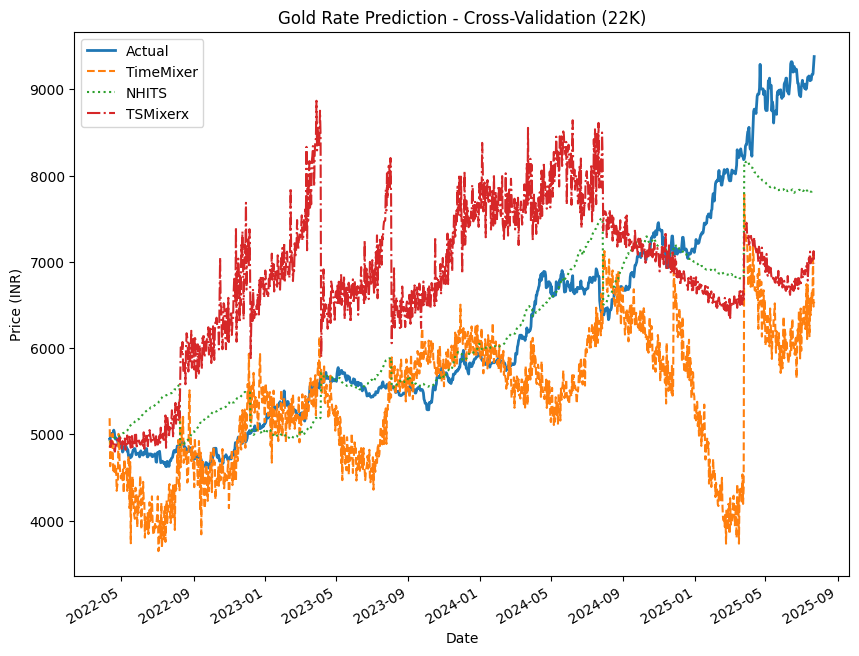

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(cv_preds_22["ds"], cv_preds_22["y"],            label="Actual",     linewidth=2)
ax.plot(cv_preds_22["ds"], cv_preds_22["TimeMixer"],    label="TimeMixer",  ls="--")
ax.plot(cv_preds_22["ds"], cv_preds_22["NHITS"],        label="NHITS",      ls=":")
ax.plot(cv_preds_22["ds"], cv_preds_22["TSMixerx"],     label="TSMixerx",   ls="-.")

ax.set_xlabel("Date")
ax.set_ylabel("Price (INR)")
ax.set_title("Gold Rate Prediction - Cross-Validation (22K)")
ax.legend()
fig.autofmt_xdate()
plt.show()

In [34]:
models = ['TimeMixer', 'NHITS', 'TSMixerx']
results = {}

for m in models:
    y_true = cv_preds_22['y'].to_numpy(dtype=float)
    y_pred = cv_preds_22[m].to_numpy(dtype=float)
    results[m] = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'SMAPE': 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
    }

results_df = pd.DataFrame(results).T
display(results_df.style.background_gradient(cmap='viridis'))
best_model = results_df['SMAPE'].idxmin()
print(f"Best model based on SMAPE: {best_model}")

,MAE,MSE,SMAPE
TimeMixer,912.967262,1863642.922245,14.675271
NHITS,371.222677,271653.097159,5.750209
TSMixerx,1232.782661,1984102.834761,18.601971


Best model based on SMAPE: NHITS


In [37]:
# Ensure cv_preds_22 is Polars
if 'polars' not in str(type(cv_preds_22)).lower():
    eval_df = pl.from_pandas(cv_preds_22)
else:
    eval_df = cv_preds_22

# Drop datetime columns safely
cols_to_drop = [c for c in ['ds', 'cutoff'] if c in eval_df.columns]
eval_df = eval_df.drop(cols_to_drop)

# Convert Polars to Pandas for simplicity with sklearn metrics
eval_df = eval_df.to_pandas()

# Evaluate models
models = ['TimeMixer', 'NHITS', 'TSMixerx']
results = {}

for m in models:
    y_true = eval_df['y'].values.astype(float)
    y_pred = eval_df[m].values.astype(float)
    results[m] = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'SMAPE': 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
    }

results_df = pd.DataFrame(results).T
display(results_df.style.background_gradient(cmap='viridis'))

best_model = results_df['SMAPE'].idxmin()
print(f"Best model based on SMAPE: {best_model}")

,MAE,MSE,SMAPE
TimeMixer,912.967262,1863642.922245,14.675271
NHITS,371.222677,271653.097159,5.750209
TSMixerx,1232.782661,1984102.834761,18.601971


Best model based on SMAPE: NHITS


In [40]:
# Ensure DE_cv_preds is Pandas for compatibility
if 'polars' in str(type(cv_preds_22)).lower():
    df_eval = cv_preds_22.to_pandas()
else:
    df_eval = cv_preds_22.copy()

# Drop any datetime columns that might break evaluation
for col in ['ds', 'cutoff']:
    if col in df_eval.columns:
        df_eval = df_eval.drop(columns=[col])

# Evaluate selected models
evaluation = evaluate(
    df_eval,
    metrics=[mae, mse],
    models=["TimeMixer", "NHITS", "TSMixerx"]
)

# Display the evaluation
display(evaluation)

,unique_id,metric,TimeMixer,NHITS,TSMixerx
0,GOLD_22K,mae,9.129673e+02,371.222677,1.232783e+03
1,GOLD_22K,mse,1.863643e+06,271653.097159,1.984103e+06


In [55]:
df_22_sorted = df_22.sort_values("ds").reset_index(drop=True)

# Pick random index from last 30 days
N = 30
test_idx = random.randint(len(df_22_sorted)-N, len(df_22_sorted)-1)
test_row = df_22_sorted.iloc[test_idx]

print("Selected test date:", test_row["ds"])
print("Actual 22K rate:", test_row["y"])

Selected test date: 2025-07-21 00:00:00
Actual 22K rate: 9180.0


In [57]:
# Select history up to the test date
history_df = df_22_sorted.iloc[:test_idx+1].copy()

# Predict next step using NeuralForecast
preds_22 = nf_24.predict(history_df.tail(INPUT_SIZE))

# preds will be a DataFrame with predictions for all models
print(preds_22)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

    unique_id         ds    TimeMixer        NHITS     TSMixerx
0    GOLD_22K 2025-07-22  9479.543945  9187.690430  8355.402344
1    GOLD_22K 2025-07-23  9598.734375  9175.791016  8478.730469
2    GOLD_22K 2025-07-24  9600.745117  9211.329102  8158.324707
3    GOLD_22K 2025-07-25  9488.460938  9194.438477  8476.521484
4    GOLD_22K 2025-07-26  9569.240234  9196.754883  8572.326172
..        ...        ...          ...          ...          ...
115  GOLD_22K 2025-11-14  9711.013672  9051.031250  8335.197266
116  GOLD_22K 2025-11-15  9889.184570  9067.652344  8372.662109
117  GOLD_22K 2025-11-16  9771.569336  9026.991211  8300.551758
118  GOLD_22K 2025-11-17  9963.548828  9049.183594  8329.348633
119  GOLD_22K 2025-11-18  9674.036133  9050.732422  8201.730469

[120 rows x 5 columns]


In [58]:
pred_next_22 = preds_22.iloc[-1]
print("Predicted 22K rates:")
print(pred_next_22)
print("Actual 22K rate:", test_row["y"])

Predicted 22K rates:
unique_id               GOLD_22K
ds           2025-11-18 00:00:00
TimeMixer            9674.036133
NHITS                9050.732422
TSMixerx             8201.730469
Name: 119, dtype: object
Actual 22K rate: 9180.0


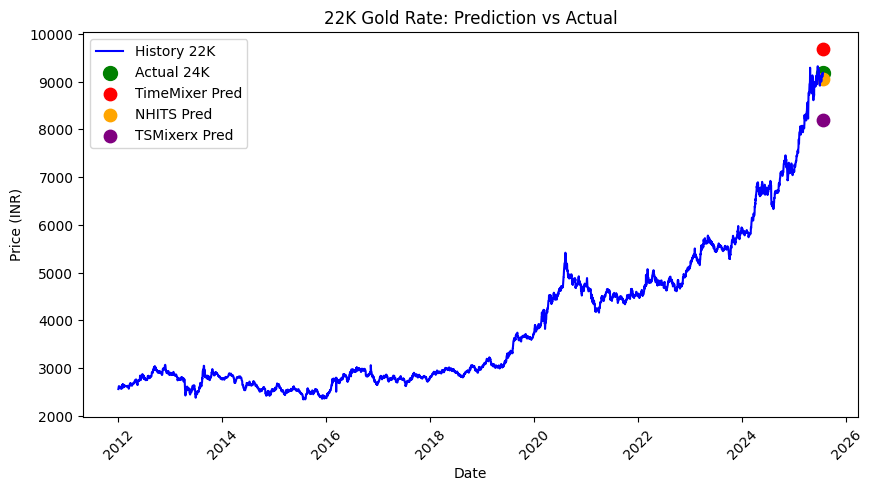

In [59]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot historical 22K gold rates
ax.plot(df_22_sorted["ds"].iloc[:test_idx+1],
        df_22_sorted["y"].iloc[:test_idx+1],
        label="History 22K", color="blue")

# Plot actual 24K rate for the selected date
ax.scatter(test_row["ds"], test_row["y"],
           color="green", label="Actual 24K", s=100)

# Plot predictions for the selected date
ax.scatter(test_row["ds"], pred_next_22["TimeMixer"], color="red", label="TimeMixer Pred", s=80)
ax.scatter(test_row["ds"], pred_next_22["NHITS"], color="orange", label="NHITS Pred", s=80)
ax.scatter(test_row["ds"], pred_next_22["TSMixerx"], color="purple", label="TSMixerx Pred", s=80)

ax.set_title("22K Gold Rate: Prediction vs Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price (INR)")
ax.legend()
plt.xticks(rotation=45)
plt.show()

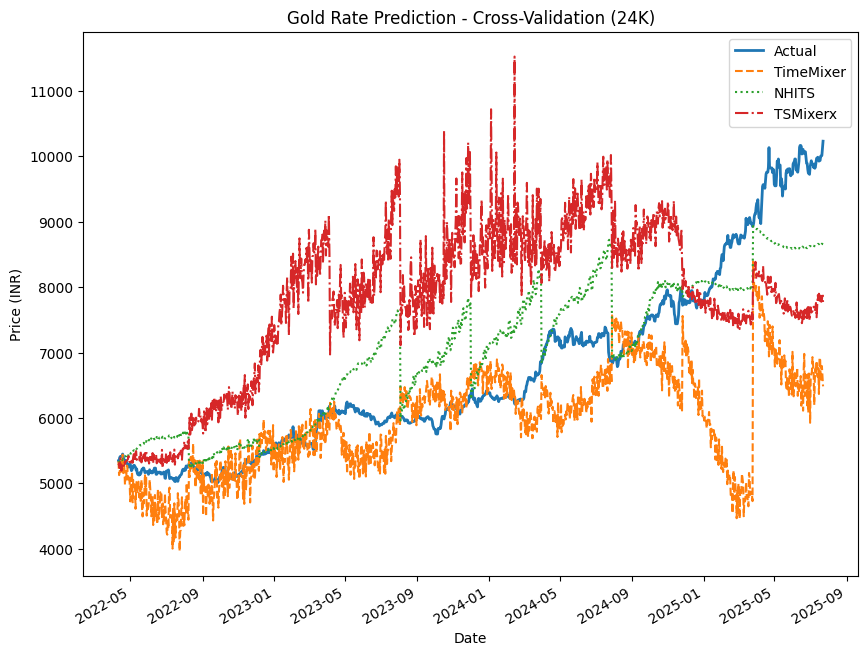

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(cv_preds_24["ds"], cv_preds_24["y"],            label="Actual",     linewidth=2)
ax.plot(cv_preds_24["ds"], cv_preds_24["TimeMixer"],    label="TimeMixer",  ls="--")
ax.plot(cv_preds_24["ds"], cv_preds_24["NHITS"],        label="NHITS",      ls=":")
ax.plot(cv_preds_24["ds"], cv_preds_24["TSMixerx"],     label="TSMixerx",   ls="-.")

ax.set_xlabel("Date")
ax.set_ylabel("Price (INR)")
ax.set_title("Gold Rate Prediction - Cross-Validation (24K)")
ax.legend()
fig.autofmt_xdate()
plt.show()

In [41]:
models = ['TimeMixer', 'NHITS', 'TSMixerx']
results = {}

for m in models:
    y_true = cv_preds_24['y'].to_numpy(dtype=float)
    y_pred = cv_preds_24[m].to_numpy(dtype=float)
    results[m] = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'SMAPE': 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
    }

results_df = pd.DataFrame(results).T
display(results_df.style.background_gradient(cmap='viridis'))
best_model = results_df['SMAPE'].idxmin()
print(f"Best model based on SMAPE: {best_model}")

,MAE,MSE,SMAPE
TimeMixer,899.564151,1940245.088501,13.041230
NHITS,587.922712,551271.030921,8.336004
TSMixerx,1611.833381,3327538.715678,21.707643


Best model based on SMAPE: NHITS


In [42]:
# Ensure cv_preds_24 is Polars
if 'polars' not in str(type(cv_preds_24)).lower():
    eval_df = pl.from_pandas(cv_preds_24)
else:
    eval_df = cv_preds_24

# Drop datetime columns safely
cols_to_drop = [c for c in ['ds', 'cutoff'] if c in eval_df.columns]
eval_df = eval_df.drop(cols_to_drop)

# Convert Polars to Pandas for simplicity with sklearn metrics
eval_df = eval_df.to_pandas()

# Evaluate models
models = ['TimeMixer', 'NHITS', 'TSMixerx']
results = {}

for m in models:
    y_true = eval_df['y'].values.astype(float)
    y_pred = eval_df[m].values.astype(float)
    results[m] = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'SMAPE': 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))
    }

results_df = pd.DataFrame(results).T
display(results_df.style.background_gradient(cmap='viridis'))

best_model = results_df['SMAPE'].idxmin()
print(f"Best model based on SMAPE: {best_model}")

,MAE,MSE,SMAPE
TimeMixer,899.564151,1940245.088501,13.041230
NHITS,587.922712,551271.030921,8.336004
TSMixerx,1611.833381,3327538.715678,21.707643


Best model based on SMAPE: NHITS


In [43]:
# Ensure DE_cv_preds is Pandas for compatibility
if 'polars' in str(type(cv_preds_24)).lower():
    df_eval = cv_preds_24.to_pandas()
else:
    df_eval = cv_preds_24.copy()

# Drop any datetime columns that might break evaluation
for col in ['ds', 'cutoff']:
    if col in df_eval.columns:
        df_eval = df_eval.drop(columns=[col])

# Evaluate selected models
evaluation = evaluate(
    df_eval,
    metrics=[mae, mse],
    models=["TimeMixer", "NHITS", "TSMixerx"]
)

# Display the evaluation
display(evaluation)

,unique_id,metric,TimeMixer,NHITS,TSMixerx
0,GOLD_24K,mae,8.995642e+02,587.922712,1.611833e+03
1,GOLD_24K,mse,1.940245e+06,551271.030921,3.327539e+06


In [48]:
df_24.head()

,unique_id,ds,y
0,GOLD_24K,2012-01-02,2738.0
1,GOLD_24K,2012-01-03,2762.0
2,GOLD_24K,2012-01-04,2778.5
3,GOLD_24K,2012-01-05,2788.0
4,GOLD_24K,2012-01-06,2805.0


In [49]:
df_24_sorted = df_24.sort_values("ds").reset_index(drop=True)

# Pick random index from last 30 days
N = 30
test_idx = random.randint(len(df_24_sorted)-N, len(df_24_sorted)-1)
test_row = df_24_sorted.iloc[test_idx]

print("Selected test date:", test_row["ds"])
print("Actual 24K rate:", test_row["y"])

Selected test date: 2025-07-12 00:00:00
Actual 24K rate: 9971.0


In [52]:
# Select history up to the test date
history_df = df_24_sorted.iloc[:test_idx+1].copy()

# Predict next step using NeuralForecast
preds = nf_24.predict(history_df.tail(INPUT_SIZE))

# preds will be a DataFrame with predictions for all models
print(preds)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

    unique_id         ds     TimeMixer         NHITS     TSMixerx
0    GOLD_24K 2025-07-13  10093.211914   9982.885742  9085.293945
1    GOLD_24K 2025-07-14  10147.738281   9995.689453  9251.458984
2    GOLD_24K 2025-07-15  10130.342773  10036.694336  8860.380859
3    GOLD_24K 2025-07-16  10000.809570  10036.800781  9271.678711
4    GOLD_24K 2025-07-17  10050.750000  10053.705078  9315.620117
..        ...        ...           ...           ...          ...
115  GOLD_24K 2025-11-05  10232.777344  10001.389648  9178.846680
116  GOLD_24K 2025-11-06  10460.216797  10011.422852  9162.381836
117  GOLD_24K 2025-11-07  10319.680664   9999.418945  9063.245117
118  GOLD_24K 2025-11-08  10526.412109   9989.878906  9106.972656
119  GOLD_24K 2025-11-09  10222.981445   9993.233398  8913.761719

[120 rows x 5 columns]


In [53]:
pred_next = preds.iloc[-1]
print("Predicted 24K rates:")
print(pred_next)
print("Actual 24K rate:", test_row["y"])

Predicted 24K rates:
unique_id               GOLD_24K
ds           2025-11-09 00:00:00
TimeMixer           10222.981445
NHITS                9993.233398
TSMixerx             8913.761719
Name: 119, dtype: object
Actual 24K rate: 9971.0


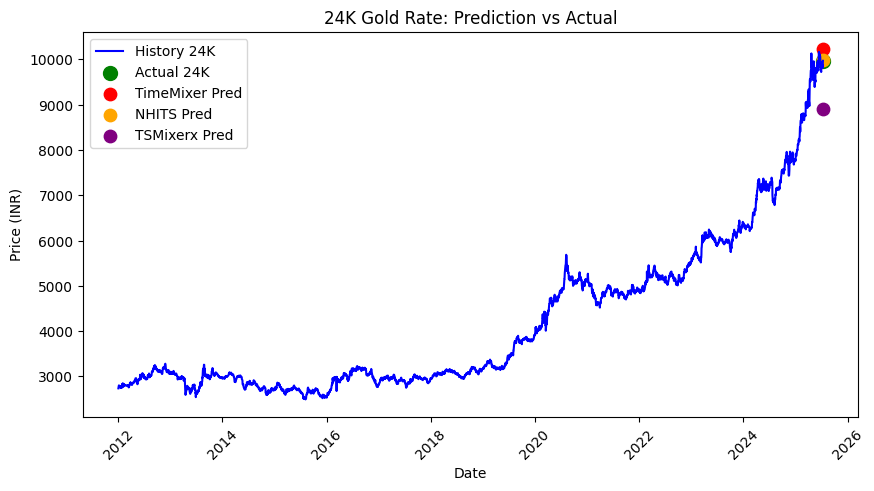

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot historical 24K gold rates
ax.plot(df_24_sorted["ds"].iloc[:test_idx+1],
        df_24_sorted["y"].iloc[:test_idx+1],
        label="History 24K", color="blue")

# Plot actual 24K rate for the selected date
ax.scatter(test_row["ds"], test_row["y"],
           color="green", label="Actual 24K", s=100)

# Plot predictions for the selected date
ax.scatter(test_row["ds"], pred_next["TimeMixer"], color="red", label="TimeMixer Pred", s=80)
ax.scatter(test_row["ds"], pred_next["NHITS"], color="orange", label="NHITS Pred", s=80)
ax.scatter(test_row["ds"], pred_next["TSMixerx"], color="purple", label="TSMixerx Pred", s=80)

ax.set_title("24K Gold Rate: Prediction vs Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price (INR)")
ax.legend()
plt.xticks(rotation=45)
plt.show()